In [133]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')


In [134]:


# Load the dataset
data = pd.read_csv('dataset.csv')

# Drop unnecessary columns
cols_to_drop = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'Unnamed: 83', 'gcs_unable_apache']
data.drop(columns=cols_to_drop, inplace=True)

# Replace "Undefined diagnoses" with "Undefined Diagnoses" in 'apache_2_bodysystem'
# This ensures consistency in category naming
data['apache_2_bodysystem'] = data['apache_2_bodysystem'].replace('Undefined diagnoses', 'Undefined Diagnoses')

# Save 'apache_4a_hospital_death_prob' and 'apache_4a_icu_death_prob' in a separate DataFrame
apache_probs = data[['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].copy()

# Drop these columns from the main dataset
data.drop(columns=['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], inplace=True)

# Display the first few rows to verify
print("Data after dropping unnecessary columns, replacing category names, and saving Apache probabilities:")
print(data.head())


Data after dropping unnecessary columns, replacing category names, and saving Apache probabilities:
    age    bmi  elective_surgery  ethnicity gender  height  \
0  68.0  22.73                 0  Caucasian      M   180.3   
1  77.0  27.42                 0  Caucasian      F   160.0   
2  25.0  31.95                 0  Caucasian      F   172.7   
3  81.0  22.64                 1  Caucasian      F   165.1   
4  19.0    NaN                 0  Caucasian      M   188.0   

            icu_admit_source icu_stay_type      icu_type  pre_icu_los_days  \
0                      Floor         admit         CTICU          0.541667   
1                      Floor         admit  Med-Surg ICU          0.927778   
2       Accident & Emergency         admit  Med-Surg ICU          0.000694   
3  Operating Room / Recovery         admit         CTICU          0.000694   
4       Accident & Emergency         admit  Med-Surg ICU          0.073611   

   ...  cirrhosis  diabetes_mellitus  hepatic_failure  imm

In [135]:
# Set display options to show all rows for missing values
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns (if needed)

# Calculate and display missing values in each column
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]

print("Missing Values in Each Column:")
print(missing_values)

# Reset display options back to default if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


Missing Values in Each Column:
age                            4228
bmi                            3429
ethnicity                      1395
gender                           25
height                         1334
icu_admit_source                112
weight                         2720
apache_2_diagnosis             1662
apache_3j_diagnosis            1101
arf_apache                      715
gcs_eyes_apache                1901
gcs_motor_apache               1901
gcs_verbal_apache              1901
heart_rate_apache               878
intubated_apache                715
map_apache                      994
resprate_apache                1234
temp_apache                    4108
ventilated_apache               715
d1_diasbp_max                   165
d1_diasbp_min                   165
d1_diasbp_noninvasive_max      1040
d1_diasbp_noninvasive_min      1040
d1_heartrate_max                145
d1_heartrate_min                145
d1_mbp_max                      220
d1_mbp_min                      2

In [136]:
# Drop any rows that have missing values
data.dropna(inplace=True)

# Alternative strategies (commented for reference):
# 1. **Impute Numerical Features:**
#    - Use mean, median, or mode to fill missing values.
# 2. **Impute Categorical Features:**
#    - Fill missing values with the most frequent category or 'Unknown'.
# 3. **Advanced Imputation Techniques:**
#    - Use K-Nearest Neighbors (KNN) or Multiple Imputation by Chained Equations (MICE).


print(f"\nData shape before dropping missing values: {data.shape}")
print(f"Data shape after dropping missing values: {data.shape}")



Data shape before dropping missing values: (61955, 77)
Data shape after dropping missing values: (61955, 77)


In [137]:
# Handle comorbidity variables
comorbidity_vars = [
    'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
    'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis'
]

# Ensure comorbidity variables are integers
data[comorbidity_vars] = data[comorbidity_vars].astype(int)

# Compute comorbidity count
data['comorbidity_count'] = data[comorbidity_vars].sum(axis=1)

# Handle GCS (Glasgow Coma Scale) variables
gcs_vars = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']

# Convert GCS variables to numeric if not already
data[gcs_vars] = data[gcs_vars].apply(pd.to_numeric)

# Compute GCS total
data['gcs_total'] = data[gcs_vars].sum(axis=1)

# Re-express categorical variables by combining certain categories

# Ethnicity: Combine 'Asian', 'Native American', 'Other/Unknown' into 'Other'
ethnicities_to_combine = ['Asian', 'Native American', 'Other/Unknown']
data['ethnicity'] = data['ethnicity'].apply(
    lambda x: x if x not in ethnicities_to_combine else 'Other'
)

# ICU Admit Source: Combine 'Other ICU' into 'Other'
icu_admit_sources_to_combine = ['Other ICU']
data['icu_admit_source'] = data['icu_admit_source'].apply(
    lambda x: x if x not in icu_admit_sources_to_combine else 'Other'
)

# ICU Type: Combine 'SICU', 'CTICU', 'CSICU' into 'Other'
icu_types_to_combine = ['SICU', 'CTICU', 'CSICU']
data['icu_type'] = data['icu_type'].apply(
    lambda x: x if x not in icu_types_to_combine else 'Other'
)

# APACHE 3J Bodysystem: Combine specific categories into 'Other'
apache_3j_bodysystem_to_combine = [
    'Gynecological',
    'Musculoskeletal/Skin',
    'Hematological',
    'Genitourinary',
    'Trauma',
    'Metabolic'
]
data['apache_3j_bodysystem'] = data['apache_3j_bodysystem'].apply(
    lambda x: x if x not in apache_3j_bodysystem_to_combine else 'Other'
)

# Drop individual comorbidity and GCS columns since we have the totals
data.drop(columns=comorbidity_vars + gcs_vars, inplace=True)

# Display the first few rows to verify feature engineering
print("Data after Feature Engineering:")
print(data.head())


Data after Feature Engineering:
     age        bmi  elective_surgery  ethnicity gender  height  \
0   68.0  22.730000                 0  Caucasian      M   180.3   
1   77.0  27.420000                 0  Caucasian      F   160.0   
5   67.0  27.560000                 0  Caucasian      M   190.5   
10  72.0  28.257052                 1   Hispanic      F   154.9   
17  46.0  25.845717                 0   Hispanic      M   167.6   

             icu_admit_source icu_stay_type      icu_type  pre_icu_los_days  \
0                       Floor         admit         Other          0.541667   
1                       Floor         admit  Med-Surg ICU          0.927778   
5        Accident & Emergency         admit  Med-Surg ICU          0.000694   
10  Operating Room / Recovery         admit  Med-Surg ICU          0.004861   
17       Accident & Emergency         admit         Other          0.000000   

    ...  h1_sysbp_noninvasive_min  d1_glucose_max  d1_glucose_min  \
0   ...              

In [138]:


#  Define Categorical Features Before Encoding
# It's crucial to define which features are categorical based on your understanding of the data.
# Adjust this list based on your dataset's actual categorical features.

categorical_features = [
    'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type',
    'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem'
]

#  Identify Numerical Features (Excluding the Target Variable)
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
if 'hospital_death' in numerical_features:
    numerical_features.remove('hospital_death')

#  Differentiate Between Binary and Continuous Numerical Features
# Binary categorical features are those categorical features with exactly two unique values
binary_columns = [col for col in categorical_features if data[col].nunique() == 2]
# Continuous numerical features are the remaining numerical features not in binary_columns
continuous_numerical_features = [col for col in numerical_features if col not in binary_columns]

#  Print Feature Lists
print("Continuous Numerical Features:")
print(continuous_numerical_features)

print("\nCategorical Features:")
print(categorical_features)

print("\nBinary Categorical Features:")
print(binary_columns)

#  Summary Statistics for Continuous Numerical Features
if continuous_numerical_features:
    print("\nSummary Statistics of Continuous Numerical Features:")
    print(data[continuous_numerical_features].describe())
else:
    print("\nNo Continuous Numerical Features to display.")

Continuous Numerical Features:
['age', 'bmi', 'elective_surgery', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sy

In [139]:


from sklearn.preprocessing import LabelEncoder

# Identify categorical features (predefined)
print("Categorical Features to Encode:")
print(categorical_features)

# Initialize LabelEncoders for each categorical column
label_encoders = {}

# Apply Label Encoding to all categorical features
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Save the encoder for future use (e.g., during inference)

# Verify that all categorical features have been encoded
print("\nData Types After Label Encoding:")
print(data.dtypes)

Categorical Features to Encode:
['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem']

Data Types After Label Encoding:
age                     float64
bmi                     float64
elective_surgery          int64
ethnicity                 int32
gender                    int32
                         ...   
apache_3j_bodysystem      int32
apache_2_bodysystem       int32
hospital_death            int64
comorbidity_count         int64
gcs_total               float64
Length: 68, dtype: object


In [140]:


from sklearn.preprocessing import LabelEncoder


print("""
**Label Encoding Explained:**

Label Encoding is a technique used to convert categorical variables into numerical form so that machine learning algorithms can process them.
Each unique category in a feature is assigned an integer value.

**Example:**
For a feature 'gender' with categories ['Male', 'Female'], Label Encoding might assign:
- 'Male' -> 0
- 'Female' -> 1

**Important Note:**
Label Encoding does not preserve any ordinal relationship unless the categories inherently have one.
For purely nominal categorical variables, One-Hot Encoding is often preferred to avoid introducing unintended ordinal relationships.

Below, we'll display the mapping of each categorical feature from its original categories to the encoded numerical values.
""")

#  Display Label Encoding Mappings for Each Categorical Feature**
for col, le in label_encoders.items():
    print(f"\n**Feature: {col}**")
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    for category, code in mapping.items():
        print(f"  {code}: {category}")



**Label Encoding Explained:**

Label Encoding is a technique used to convert categorical variables into numerical form so that machine learning algorithms can process them.
Each unique category in a feature is assigned an integer value.

**Example:**
For a feature 'gender' with categories ['Male', 'Female'], Label Encoding might assign:
- 'Male' -> 0
- 'Female' -> 1

**Important Note:**
Label Encoding does not preserve any ordinal relationship unless the categories inherently have one.
For purely nominal categorical variables, One-Hot Encoding is often preferred to avoid introducing unintended ordinal relationships.

Below, we'll display the mapping of each categorical feature from its original categories to the encoded numerical values.


**Feature: ethnicity**
  0: African American
  1: Caucasian
  2: Hispanic
  3: Other

**Feature: gender**
  0: F
  1: M

**Feature: icu_admit_source**
  0: Accident & Emergency
  1: Floor
  2: Operating Room / Recovery
  3: Other
  4: Other Hospital

In [141]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
import joblib
import warnings
warnings.filterwarnings('ignore')

# Assuming 'data' is your preprocessed DataFrame from previous cells
# Ensure 'data' has no missing values and categorical variables are already encoded

#  Define Features and Target Variable
# Replace 'hospital_death' with your actual target column name
target_column = 'hospital_death'  # Example target column

# Check if the target column exists
if target_column not in data.columns:
    raise ValueError(f"Target column '{target_column}' not found in the dataset. Please check the column name.")

# Define Features (X) and Target (y)
X = data.drop(columns=[target_column])
y = data[target_column]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}\n")

#  Identify Numerical and Categorical Columns

# Define categorical features based on your dataset
categorical_features = [
    'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type',
    'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem'
]

# Identify numerical columns (excluding the target variable)
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

print("Numerical Features:")
print(numerical_features, "\n")

print("Categorical Features:")
print(categorical_features, "\n")

#  Scale Numerical Features with StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns
X[numerical_features] = scaler.fit_transform(X[numerical_features])

print("Numerical Features After Scaling:")
print(pd.DataFrame(X[numerical_features], columns=numerical_features).head(), "\n")

#  Split the Data into Training and Testing Sets

# Split the data into training and testing sets (80% train, 20% test)
# Stratify based on the target variable to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}\n")

print("Training Target Distribution:")
print(y_train.value_counts(normalize=True), "\n")

print("Testing Target Distribution:")
print(y_test.value_counts(normalize=True), "\n")

#  Handle Class Imbalance with SMOTENC

# Since your data is heavily imbalanced, applying SMOTENC to the training set is beneficial
print("Applying SMOTENC to the training data to handle class imbalance...")

# Identify the indices of categorical features in X_train
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_features]

# Initialize SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)

# Apply SMOTENC to the training data
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)

print("After SMOTENC:")
print(y_train_smote.value_counts(normalize=True), "\n")

# Save the Scaler and SMOTENC Objects for Future Use

# Save the scaler
joblib.dump(scaler, 'standard_scaler.joblib')
print("Scaler has been saved as 'standard_scaler.joblib'.")

# Save the SMOTENC object
joblib.dump(smote_nc, 'smotenc_resampler.joblib')
print("SMOTENC object has been saved as 'smotenc_resampler.joblib'.")

#  Save the Datasets for Different Resampling Strategies

# Save the original training set (without SMOTENC)
X_train_original = X_train.copy()
y_train_original = y_train.copy()

# Save the SMOTENC-resampled training set
X_train_resampled = X_train_smote.copy()
y_train_resampled = y_train_smote.copy()

# Save the original testing set
X_test_original = X_test.copy()
y_test_original = y_test.copy()

print("\nPreprocessing completed. Three datasets are ready:")
print("- `X_train_original`, `y_train_original`: Original training data without resampling.")
print("- `X_train_resampled`, `y_train_resampled`: Training data after applying SMOTENC.")
print("- `X_test_original`, `y_test_original`: Original testing data.\n")




Features shape: (61955, 67)
Target shape: (61955,)

Numerical Features:
['age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1

In [143]:
#  Define the MLP Model Architecture and Training Function 

import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=50, patience=5):
    best_loss = float('inf')
    trigger_times = 0
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            trigger_times = 0
            torch.save(model.state_dict(), f'best_model_fold{fold+1}.pth')
        else:
            trigger_times += 1
            print(f"EarlyStopping counter: {trigger_times} out of {patience}")
            if trigger_times >= patience:
                print("Early stopping triggered!")
                break
    model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))
    return model, history


Epoch [1/50], Train Loss: 0.2515, Val Loss: 0.2221
Epoch [2/50], Train Loss: 0.2220, Val Loss: 0.2190
Epoch [3/50], Train Loss: 0.2188, Val Loss: 0.2166
Epoch [4/50], Train Loss: 0.2158, Val Loss: 0.2147
Epoch [5/50], Train Loss: 0.2136, Val Loss: 0.2141
Epoch [6/50], Train Loss: 0.2113, Val Loss: 0.2153
EarlyStopping counter: 1 out of 5
Epoch [7/50], Train Loss: 0.2092, Val Loss: 0.2136
Epoch [8/50], Train Loss: 0.2100, Val Loss: 0.2119
Epoch [9/50], Train Loss: 0.2062, Val Loss: 0.2121
EarlyStopping counter: 1 out of 5
Epoch [10/50], Train Loss: 0.2070, Val Loss: 0.2125
EarlyStopping counter: 2 out of 5
Epoch [11/50], Train Loss: 0.2061, Val Loss: 0.2129
EarlyStopping counter: 3 out of 5
Epoch [12/50], Train Loss: 0.2040, Val Loss: 0.2128
EarlyStopping counter: 4 out of 5
Epoch [13/50], Train Loss: 0.2035, Val Loss: 0.2119
EarlyStopping counter: 5 out of 5
Early stopping triggered!
Epoch [1/50], Train Loss: 0.2468, Val Loss: 0.2149
Epoch [2/50], Train Loss: 0.2217, Val Loss: 0.2148
E

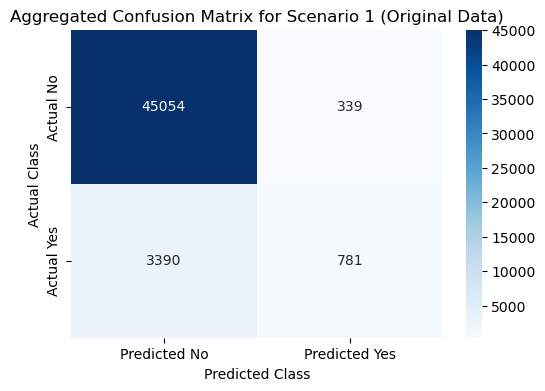

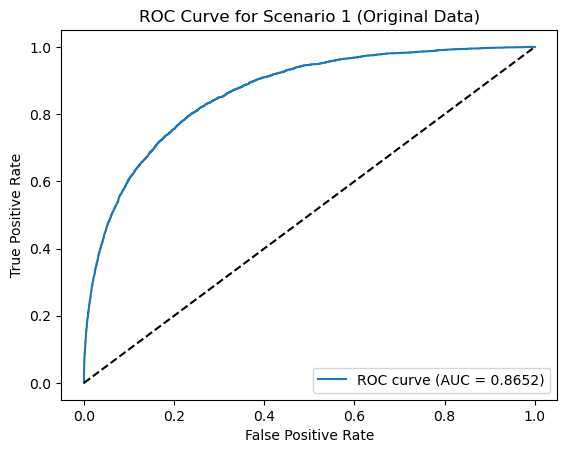

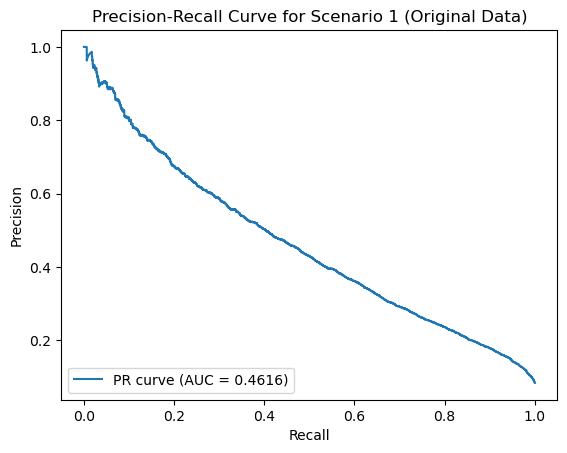


Classification Report for Scenario 1 (Original Data):
              precision    recall  f1-score   support

         0.0     0.9300    0.9925    0.9603     45393
         1.0     0.6973    0.1872    0.2952      4171

    accuracy                         0.9248     49564
   macro avg     0.8137    0.5899    0.6277     49564
weighted avg     0.9104    0.9248    0.9043     49564



In [144]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize K-Fold Cross-Validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Prepare data
X = X_train_original.values
y = y_train_original.values

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Initialize lists to store metrics
fold_confusion_matrices = []
fold_roc_auc_scores = []
fold_avg_precision_scores = []
all_y_true = []
all_y_pred_probs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32).unsqueeze(1)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32).unsqueeze(1)

    # Create DataLoaders
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)

    # Initialize the model
    input_dim = X.shape[1]
    model = MLP(input_dim).to(device)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    model, _ = train_model(model, criterion, optimizer, train_loader, val_loader,
                       device, num_epochs=50, patience=5) 

    # Evaluation
    model.eval()
    y_true_fold = []
    y_pred_probs_fold = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch.to(device))
            y_pred_probs_fold.extend(outputs.cpu().numpy())
            y_true_fold.extend(y_batch.numpy())

    # Confusion Matrix
    y_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_pred_probs_fold]
    fold_confusion_matrices.append(confusion_matrix(y_true_fold, y_pred_binary))

    # ROC AUC and PR AUC Scores
    roc_auc = roc_auc_score(y_true_fold, y_pred_probs_fold)
    avg_precision = average_precision_score(y_true_fold, y_pred_probs_fold)
    fold_roc_auc_scores.append(roc_auc)
    fold_avg_precision_scores.append(avg_precision)

    # Collect all predictions
    all_y_true.extend(y_true_fold)
    all_y_pred_probs.extend(y_pred_probs_fold)

# Calculate average ROC AUC and PR AUC
avg_roc_auc = np.mean(fold_roc_auc_scores)
avg_avg_precision = np.mean(fold_avg_precision_scores)
print(f"Average ROC AUC across {k_folds} folds: {avg_roc_auc:.4f}")
print(f"Average PR AUC across {k_folds} folds: {avg_avg_precision:.4f}")

# Aggregate Confusion Matrix
aggregated_cm = np.sum(fold_confusion_matrices, axis=0)

# Plot Aggregated Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(aggregated_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Aggregated Confusion Matrix for Scenario 1 (Original Data)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_y_true, all_y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {avg_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Scenario 1 (Original Data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_y_true, all_y_pred_probs)
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AUC = {avg_avg_precision:.4f})')
plt.title('Precision-Recall Curve for Scenario 1 (Original Data)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

# Overall Classification Report
print("\nClassification Report for Scenario 1 (Original Data):")
print(classification_report(all_y_true, [1 if prob >= 0.5 else 0 for prob in all_y_pred_probs], digits=4))



Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

         0.0     0.9442    0.9683    0.9561     45393
         1.0     0.5221    0.3771    0.4379      4171

    accuracy                         0.9185     49564
   macro avg     0.7331    0.6727    0.6970     49564
weighted avg     0.9087    0.9185    0.9125     49564



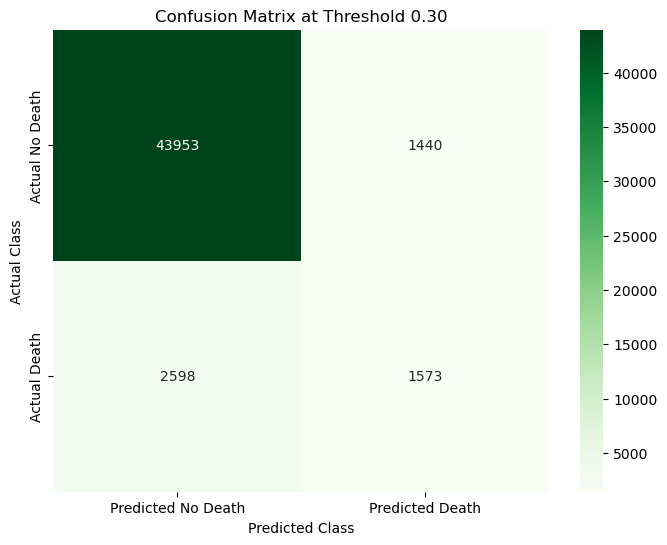

In [145]:
#  Manual Threshold Adjustment 

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define your desired threshold
threshold = 0.3  # Adjust this value as needed

# Apply the threshold to get binary predictions
y_pred_optimal = [1 if prob >= threshold else 0 for prob in all_y_pred_probs]

# Generate Classification Report
print("\nClassification Report with Adjusted Threshold:")
print(classification_report(all_y_true, y_pred_optimal, digits=4, zero_division=0))

# Generate and plot Confusion Matrix
cm_optimal = confusion_matrix(all_y_true, y_pred_optimal)
plt.figure(figsize=(8,6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted No Death', 'Predicted Death'],
            yticklabels=['Actual No Death', 'Actual Death'])
plt.title(f'Confusion Matrix at Threshold {threshold:.2f}')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


Epoch [1/50], Train Loss: 0.4646, Val Loss: 0.4151
Epoch [2/50], Train Loss: 0.4188, Val Loss: 0.3692
Epoch [3/50], Train Loss: 0.3486, Val Loss: 0.2692
Epoch [4/50], Train Loss: 0.3039, Val Loss: 0.2463
Epoch [5/50], Train Loss: 0.2908, Val Loss: 0.2356
Epoch [6/50], Train Loss: 0.2849, Val Loss: 0.2313
Epoch [7/50], Train Loss: 0.2701, Val Loss: 0.2257
Epoch [8/50], Train Loss: 0.2726, Val Loss: 0.2240
Epoch [9/50], Train Loss: 0.2652, Val Loss: 0.2211
Epoch [10/50], Train Loss: 0.2559, Val Loss: 0.2184
Epoch [11/50], Train Loss: 0.2513, Val Loss: 0.2130
Epoch [12/50], Train Loss: 0.2475, Val Loss: 0.2097
Epoch [13/50], Train Loss: 0.2503, Val Loss: 0.2088
Epoch [14/50], Train Loss: 0.2413, Val Loss: 0.2083
Epoch [15/50], Train Loss: 0.2496, Val Loss: 0.2061
Epoch [16/50], Train Loss: 0.2379, Val Loss: 0.2080
EarlyStopping counter: 1 out of 5
Epoch [17/50], Train Loss: 0.2395, Val Loss: 0.2051
Epoch [18/50], Train Loss: 0.2338, Val Loss: 0.1952
Epoch [19/50], Train Loss: 0.2328, Val 

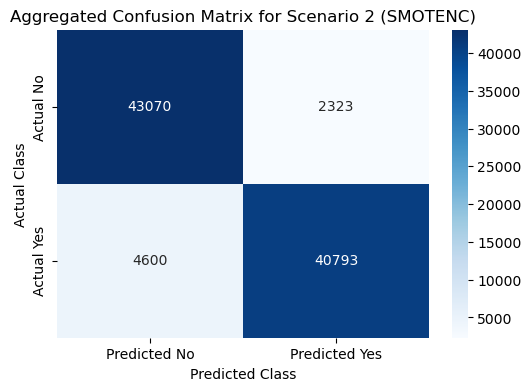

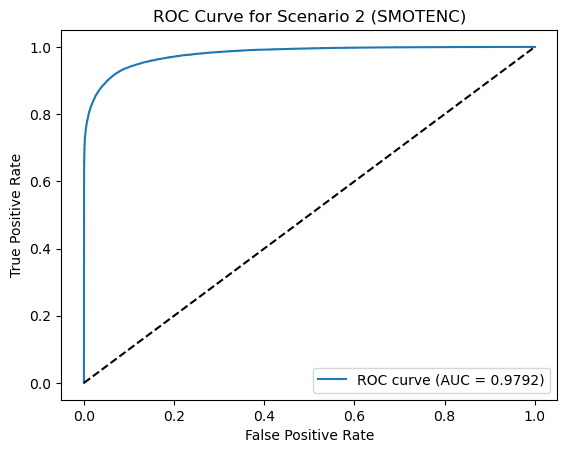

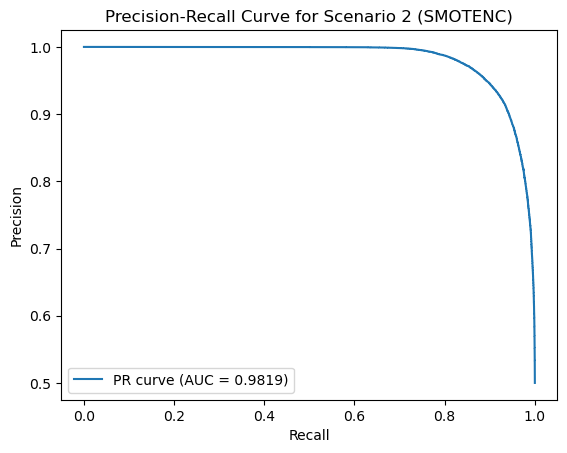


Classification Report for Scenario 2 (SMOTENC):
              precision    recall  f1-score   support

         0.0     0.9035    0.9488    0.9256     45393
         1.0     0.9461    0.8987    0.9218     45393

    accuracy                         0.9237     90786
   macro avg     0.9248    0.9237    0.9237     90786
weighted avg     0.9248    0.9237    0.9237     90786



In [147]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize K-Fold Cross-Validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Prepare SMOTENC-resampled data
categorical_features_indices = [0, 1, 2]  # Replace with actual indices
smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train_original, y_train_original)

# Convert to numpy arrays
X_resampled = np.array(X_resampled)
y_resampled = np.array(y_resampled)

# Initialize lists to store metrics
fold_confusion_matrices_smotenc = []
fold_roc_auc_scores_smotenc = []
fold_avg_precision_scores_smotenc = []
all_y_true_smotenc = []
all_y_pred_probs_smotenc = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_resampled, y_resampled), 1):
    X_train_fold, X_val_fold = X_resampled[train_idx], X_resampled[val_idx]
    y_train_fold, y_val_fold = y_resampled[train_idx], y_resampled[val_idx]

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32).unsqueeze(1)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32).unsqueeze(1)

    # Create DataLoaders
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)

    # Initialize the model
    input_dim = X_resampled.shape[1]
    model = MLP(input_dim).to(device)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    model, _ = train_model(model, criterion, optimizer, train_loader, val_loader,
                       device, num_epochs=50, patience=5)

    # Evaluation
    model.eval()
    y_true_fold = []
    y_pred_probs_fold = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch.to(device))
            y_pred_probs_fold.extend(outputs.cpu().numpy())
            y_true_fold.extend(y_batch.numpy())

    # Confusion Matrix
    y_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_pred_probs_fold]
    fold_confusion_matrices_smotenc.append(confusion_matrix(y_true_fold, y_pred_binary))

    # ROC AUC and PR AUC Scores
    roc_auc = roc_auc_score(y_true_fold, y_pred_probs_fold)
    avg_precision = average_precision_score(y_true_fold, y_pred_probs_fold)
    fold_roc_auc_scores_smotenc.append(roc_auc)
    fold_avg_precision_scores_smotenc.append(avg_precision)

    # Collect all predictions
    all_y_true_smotenc.extend(y_true_fold)
    all_y_pred_probs_smotenc.extend(y_pred_probs_fold)

# Calculate average ROC AUC and PR AUC
avg_roc_auc_smotenc = np.mean(fold_roc_auc_scores_smotenc)
avg_avg_precision_smotenc = np.mean(fold_avg_precision_scores_smotenc)
print(f"Average ROC AUC across {k_folds} folds: {avg_roc_auc_smotenc:.4f}")
print(f"Average PR AUC across {k_folds} folds: {avg_avg_precision_smotenc:.4f}")

# Aggregate Confusion Matrix
aggregated_cm_smotenc = np.sum(fold_confusion_matrices_smotenc, axis=0)

# Plot Aggregated Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(aggregated_cm_smotenc, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Aggregated Confusion Matrix for Scenario 2 (SMOTENC)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Plot ROC Curve
fpr_smotenc, tpr_smotenc, _ = roc_curve(all_y_true_smotenc, all_y_pred_probs_smotenc)
plt.figure()
plt.plot(fpr_smotenc, tpr_smotenc, label=f'ROC curve (AUC = {avg_roc_auc_smotenc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Scenario 2 (SMOTENC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curve
precision_smotenc, recall_smotenc, _ = precision_recall_curve(all_y_true_smotenc, all_y_pred_probs_smotenc)
plt.figure()
plt.plot(recall_smotenc, precision_smotenc, label=f'PR curve (AUC = {avg_avg_precision_smotenc:.4f})')
plt.title('Precision-Recall Curve for Scenario 2 (SMOTENC)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

# Overall Classification Report
print("\nClassification Report for Scenario 2 (SMOTENC):")
print(classification_report(all_y_true_smotenc, [1 if prob >= 0.5 else 0 for prob in all_y_pred_probs_smotenc], digits=4))



Classification Report for Scenario 2 (SMOTENC) with Adjusted Threshold:
              precision    recall  f1-score   support

         0.0     0.9270    0.9210    0.9240     45393
         1.0     0.9215    0.9275    0.9245     45393

    accuracy                         0.9242     90786
   macro avg     0.9243    0.9242    0.9242     90786
weighted avg     0.9243    0.9242    0.9242     90786



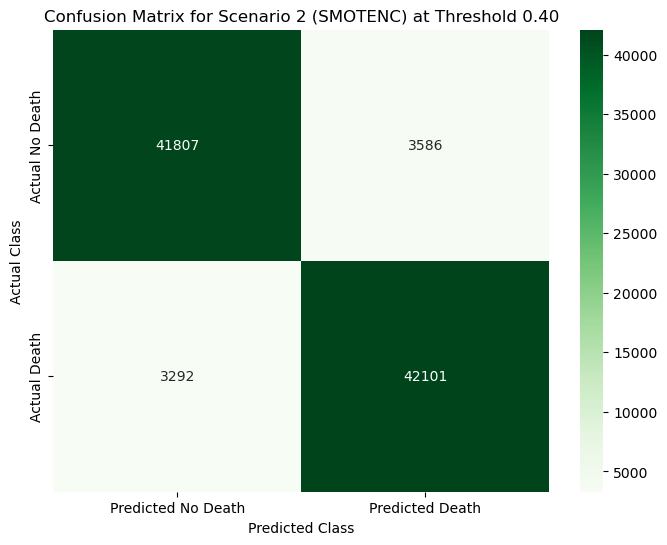

In [148]:
#  Manual Threshold Adjustment for Scenario 2 (SMOTENC) 

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define your desired threshold
threshold_s2 = 0.4  # Adjust this value as needed

# Apply the threshold to get binary predictions
y_pred_optimal_s2 = [1 if prob >= threshold_s2 else 0 for prob in all_y_pred_probs_smotenc]

# Generate Classification Report
print("\nClassification Report for Scenario 2 (SMOTENC) with Adjusted Threshold:")
print(classification_report(all_y_true_smotenc, y_pred_optimal_s2, digits=4, zero_division=0))

# Generate and plot Confusion Matrix
cm_optimal_s2 = confusion_matrix(all_y_true_smotenc, y_pred_optimal_s2)
plt.figure(figsize=(8,6))
sns.heatmap(cm_optimal_s2, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted No Death', 'Predicted Death'],
            yticklabels=['Actual No Death', 'Actual Death'])
plt.title(f'Confusion Matrix for Scenario 2 (SMOTENC) at Threshold {threshold_s2:.2f}')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

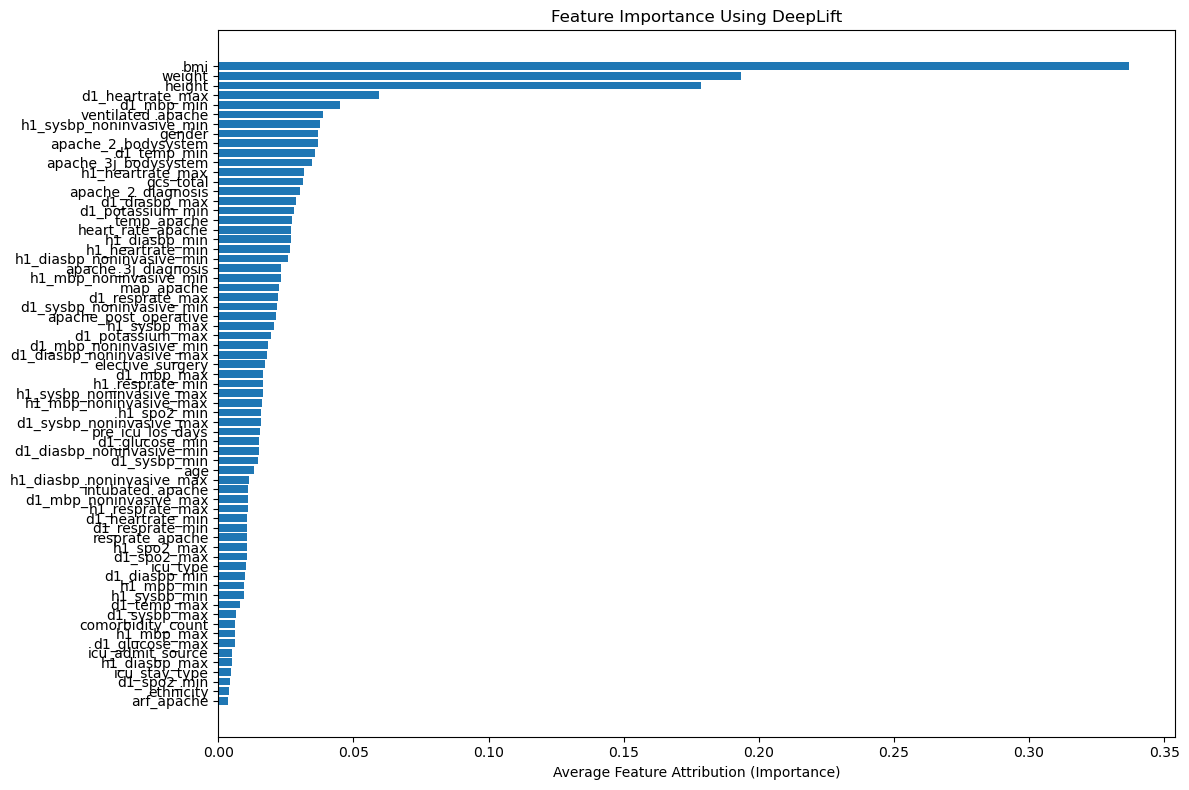

In [149]:
import torch
from captum.attr import DeepLift
import numpy as np
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Define baseline and input data
baseline = torch.zeros_like(torch.tensor(X_test_original[:10].values, dtype=torch.float32)).to(device)
input_data = torch.tensor(X_test_original[:10].values, dtype=torch.float32).to(device)

# Initialize DeepLift for SHAP-like explanations
deeplift = DeepLift(model)

# Compute feature attributions
attributions = deeplift.attribute(input_data, baselines=baseline)

# Convert attributions to numpy for visualization
attributions_np = attributions.detach().cpu().numpy()

# Average attributions across all instances to summarize feature importance
feature_importance = np.abs(attributions_np).mean(axis=0)

# Create a DataFrame for sorting
importance_df = pd.DataFrame({
    'Feature': X_test_original.columns,
    'Importance': feature_importance
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot sorted feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.xlabel("Average Feature Attribution (Importance)")
plt.title("Feature Importance Using DeepLift")
plt.tight_layout()
plt.show()

Epoch [1/50], Train Loss: 1.1509, Val Loss: 1.1319
Epoch [2/50], Train Loss: 1.1213, Val Loss: 1.1275
Epoch [3/50], Train Loss: 1.1160, Val Loss: 1.1240
Epoch [4/50], Train Loss: 1.1134, Val Loss: 1.1246
EarlyStopping counter: 1 out of 5
Epoch [5/50], Train Loss: 1.1113, Val Loss: 1.1226
Epoch [6/50], Train Loss: 1.1120, Val Loss: 1.1215
Epoch [7/50], Train Loss: 1.1120, Val Loss: 1.1280
EarlyStopping counter: 1 out of 5
Epoch [8/50], Train Loss: 1.1102, Val Loss: 1.1240
EarlyStopping counter: 2 out of 5
Epoch [9/50], Train Loss: 1.1088, Val Loss: 1.1242
EarlyStopping counter: 3 out of 5
Epoch [10/50], Train Loss: 1.1078, Val Loss: 1.1208
Epoch [11/50], Train Loss: 1.1086, Val Loss: 1.1211
EarlyStopping counter: 1 out of 5
Epoch [12/50], Train Loss: 1.1053, Val Loss: 1.1228
EarlyStopping counter: 2 out of 5
Epoch [13/50], Train Loss: 1.1029, Val Loss: 1.1206
Epoch [14/50], Train Loss: 1.1029, Val Loss: 1.1206
Epoch [15/50], Train Loss: 1.1016, Val Loss: 1.1230
EarlyStopping counter: 1 

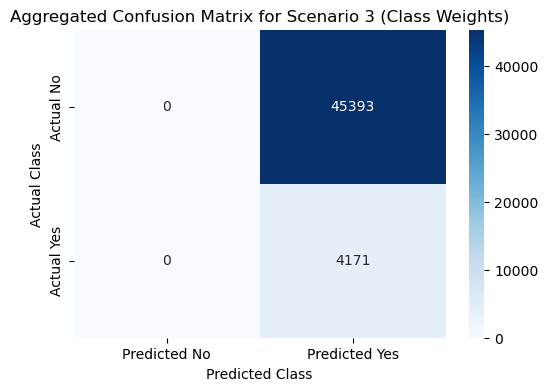

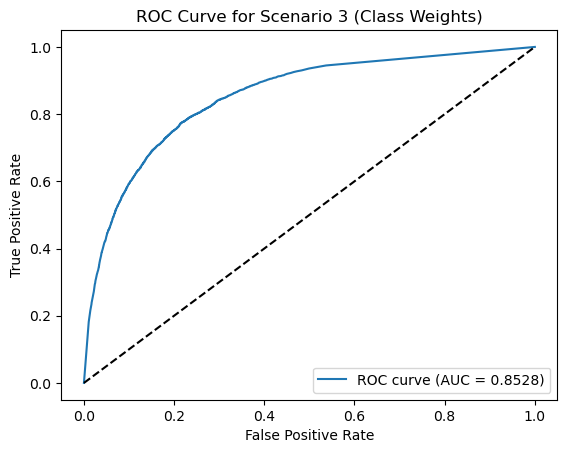

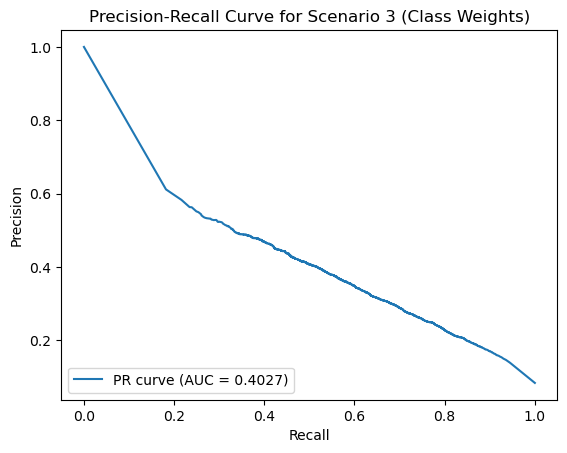


Classification Report for Scenario 3 (Class Weights):
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000     45393
         1.0     0.0842    1.0000    0.1552      4171

    accuracy                         0.0842     49564
   macro avg     0.0421    0.5000    0.0776     49564
weighted avg     0.0071    0.0842    0.0131     49564



In [150]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize K-Fold Cross-Validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Compute class weights
classes = np.unique(y_train_original)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_original)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Prepare data
X = X_train_original.values
y = y_train_original.values

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Initialize lists to store metrics
fold_confusion_matrices_weights = []
fold_roc_auc_scores_weights = []
fold_avg_precision_scores_weights = []
all_y_true_weights = []
all_y_pred_probs_weights = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32).unsqueeze(1)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32).unsqueeze(1)

    # Create DataLoaders
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)

    # Initialize the model
    input_dim = X.shape[1]
    model = MLP(input_dim).to(device)

    # Define loss function with class weights
    pos_weight = class_weights[1] / class_weights[0]
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    odel, _ = train_model(model, criterion, optimizer, train_loader, val_loader,
                       device, num_epochs=50, patience=5)

    # Evaluation
    model.eval()
    y_true_fold = []
    y_pred_probs_fold = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch.to(device))
            probs = torch.sigmoid(outputs)
            y_pred_probs_fold.extend(probs.cpu().numpy())
            y_true_fold.extend(y_batch.numpy())

    # Confusion Matrix
    y_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_pred_probs_fold]
    fold_confusion_matrices_weights.append(confusion_matrix(y_true_fold, y_pred_binary))

    # ROC AUC and PR AUC Scores
    roc_auc = roc_auc_score(y_true_fold, y_pred_probs_fold)
    avg_precision = average_precision_score(y_true_fold, y_pred_probs_fold)
    fold_roc_auc_scores_weights.append(roc_auc)
    fold_avg_precision_scores_weights.append(avg_precision)

    # Collect all predictions
    all_y_true_weights.extend(y_true_fold)
    all_y_pred_probs_weights.extend(y_pred_probs_fold)

# Calculate average ROC AUC and PR AUC
avg_roc_auc_weights = np.mean(fold_roc_auc_scores_weights)
avg_avg_precision_weights = np.mean(fold_avg_precision_scores_weights)
print(f"Average ROC AUC across {k_folds} folds: {avg_roc_auc_weights:.4f}")
print(f"Average PR AUC across {k_folds} folds: {avg_avg_precision_weights:.4f}")

# Aggregate Confusion Matrix
aggregated_cm_weights = np.sum(fold_confusion_matrices_weights, axis=0)

# Plot Aggregated Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(aggregated_cm_weights, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Aggregated Confusion Matrix for Scenario 3 (Class Weights)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Plot ROC Curve
fpr_weights, tpr_weights, _ = roc_curve(all_y_true_weights, all_y_pred_probs_weights)
plt.figure()
plt.plot(fpr_weights, tpr_weights, label=f'ROC curve (AUC = {avg_roc_auc_weights:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Scenario 3 (Class Weights)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curve
precision_weights, recall_weights, _ = precision_recall_curve(all_y_true_weights, all_y_pred_probs_weights)
plt.figure()
plt.plot(recall_weights, precision_weights, label=f'PR curve (AUC = {avg_avg_precision_weights:.4f})')
plt.title('Precision-Recall Curve for Scenario 3 (Class Weights)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

# Overall Classification Report
print("\nClassification Report for Scenario 3 (Class Weights):")
print(classification_report(all_y_true_weights, [1 if prob >= 0.5 else 0 for prob in all_y_pred_probs_weights], digits=4))



Classification Report for Scenario 3 (Class Weights) with Adjusted Threshold:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000     45393
         1.0     0.0842    1.0000    0.1552      4171

    accuracy                         0.0842     49564
   macro avg     0.0421    0.5000    0.0776     49564
weighted avg     0.0071    0.0842    0.0131     49564



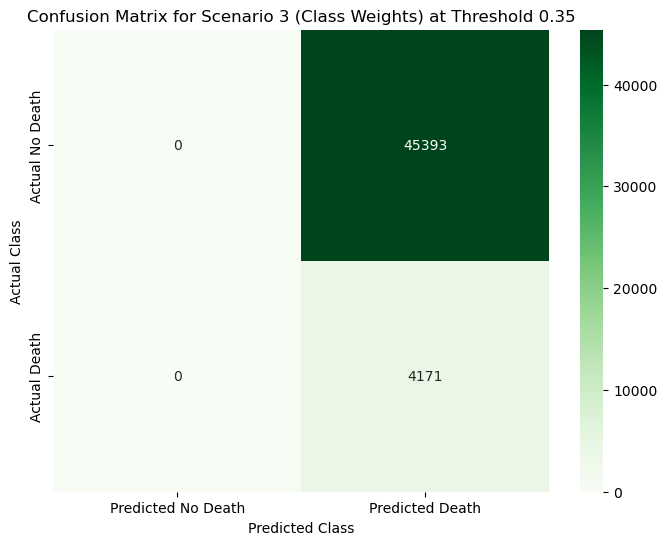

In [151]:
#  Manual Threshold Adjustment for Scenario 3 (Class Weights)

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define your desired threshold
threshold_s3 = 0.35  # Adjust this value as needed

# Apply the threshold to get binary predictions
y_pred_optimal_s3 = [1 if prob >= threshold_s3 else 0 for prob in all_y_pred_probs_weights]

# Generate Classification Report
print("\nClassification Report for Scenario 3 (Class Weights) with Adjusted Threshold:")
print(classification_report(all_y_true_weights, y_pred_optimal_s3, digits=4, zero_division=0))

# Generate and plot Confusion Matrix
cm_optimal_s3 = confusion_matrix(all_y_true_weights, y_pred_optimal_s3)
plt.figure(figsize=(8,6))
sns.heatmap(cm_optimal_s3, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted No Death', 'Predicted Death'],
            yticklabels=['Actual No Death', 'Actual Death'])
plt.title(f'Confusion Matrix for Scenario 3 (Class Weights) at Threshold {threshold_s3:.2f}')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()
